<a href="https://colab.research.google.com/github/tennille-bernard/Kal-Academy-Assignments/blob/main/Assignment_5_TB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal:** Build an RNN model to help predict Microsoft stock using a LSTM.  
Datasource: https://finance.yahoo.com/quote/MSFT/history/?p=MSFT (pulled on Apr 03, 2025)

**Import packages**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Dropout, Dense, LSTM

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

**Loading data and preprocessing**

In [2]:
df = pd.read_csv('MSFT_Stock_Price_20250403.csv')

**Data preprocessing & augmentation - part 1**

In [3]:
#dropping non-float values from dataset.
def drop_non_float(df, column_name):
    """
    Drops rows from a DataFrame where the specified column does not contain float values.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to filter.

    Returns:
        pd.DataFrame: A new DataFrame with non-float rows removed.
    """
    df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
    df = df.dropna(subset=['Open'])
    return df

In [4]:
dataset_cleaned = drop_non_float(df, 'Open')
print(dataset_cleaned)

          Date    Open    High     Low   Close  Adj Close      Volume
0     4/4/2024  424.99  428.67  417.57  417.88     414.71  19,370,900
1     4/5/2024  420.01  426.51  418.32  425.52     422.30  16,544,300
2     4/8/2024  425.17  427.28  423.30  424.59     421.37  14,272,400
3     4/9/2024  426.44  427.74  421.62  426.28     423.05  12,512,300
4    4/10/2024  422.19  424.03  419.70  423.26     420.05  16,216,600
..         ...     ...     ...     ...     ...        ...         ...
250  3/28/2025  388.08  389.13  376.93  378.80     378.80  21,632,000
251  3/31/2025  372.54  377.07  367.24  375.39     375.39  35,184,700
252   4/1/2025  374.65  382.85  373.23  382.19     382.19  19,689,500
253   4/2/2025  377.97  385.08  376.62  382.14     382.14  16,092,600
254   4/3/2025  374.79  377.45  369.35  373.11     373.11  30,037,817

[251 rows x 7 columns]


In [5]:
#reindexing the index column so that it is continuous.
dataset_cleaned = dataset_cleaned.reset_index(drop=True)
print(dataset_cleaned)

          Date    Open    High     Low   Close  Adj Close      Volume
0     4/4/2024  424.99  428.67  417.57  417.88     414.71  19,370,900
1     4/5/2024  420.01  426.51  418.32  425.52     422.30  16,544,300
2     4/8/2024  425.17  427.28  423.30  424.59     421.37  14,272,400
3     4/9/2024  426.44  427.74  421.62  426.28     423.05  12,512,300
4    4/10/2024  422.19  424.03  419.70  423.26     420.05  16,216,600
..         ...     ...     ...     ...     ...        ...         ...
246  3/28/2025  388.08  389.13  376.93  378.80     378.80  21,632,000
247  3/31/2025  372.54  377.07  367.24  375.39     375.39  35,184,700
248   4/1/2025  374.65  382.85  373.23  382.19     382.19  19,689,500
249   4/2/2025  377.97  385.08  376.62  382.14     382.14  16,092,600
250   4/3/2025  374.79  377.45  369.35  373.11     373.11  30,037,817

[251 rows x 7 columns]


There are 251 rows + 1 header.  We can use the sliding block technique and work in 10 blocks of 25 records each.

In [6]:
#Setting test_set to everything but the latest 20 readings and training set to all except the latest 20 readings.
#training_set = file_path.iloc[:-25:, :]
#test_set =  file_path.iloc[-15, :]
#df = pd.read_csv(file_path)

#Setting test_set to everything but the latest 20 readings and training set to all except the latest 20 readings.
training_set = dataset_cleaned.iloc[:-25, 1:2] #Up to last 25 rows aka historical data
test_set =  dataset_cleaned.iloc[-25:, 1:2] #Last 25 rows to end aka most recent data.

In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [9]:
X_train = []
y_train = []
for i in range(25, 226):
    X_train.append(training_set_scaled[i-25:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)  #puts the data into a 1D array

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#reshapes the 1D array into a 3D array for the LSTM model.

**Building the LSTM model** which eliminates the issue with the vanishing gradient.

In [11]:
regressor = models.Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))  #Final output.
regressor.add(Dropout(0.2))

In [13]:
regressor.add(Dense(units = 1)) # Last output layer

**Compile and retrain the model** using optimizer = 'adam' and loss = MSE because this model is similar to a regression model.

In [14]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.2166
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0568
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0499
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0356
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0367
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0327
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0318
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0351
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0326
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0347
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0357
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0309
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0285
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0297
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0335
Epoch 16/100
7/7 ━━

**Data augmentation part 2**

In [20]:
test_set_scaled = sc.fit_transform(test_set)

In [25]:
#to promote a smooth transition between training and testing data, we take the last 15 rows of the training data as input for the test data.
X_test = []
for i in range(1,25):
    X_test.append(test_set_scaled[i:i+1, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) #convert to 1D array

**Predicting the stock price**

In [28]:
predicted_stock_price = regressor.predict(X_test) #predicted stock price in the form of 0 to 1
predicted_stock_price = sc.inverse_transform(predicted_stock_price) #inverse transformation to get the actual price in dollars
print('The predicted price of Microsoft stock is ', predicted_stock_price[-1], '.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
The predicted price of Microsoft stock is  [375.06744] .


**Visualizing prediction vs actual Microsoft Stock Price**

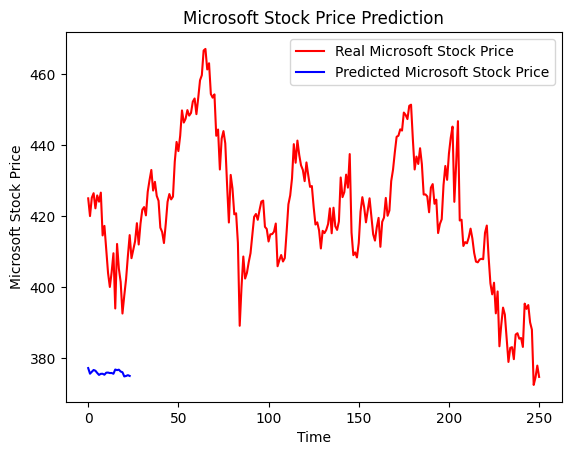

In [30]:
real_stock_price = dataset_cleaned.iloc[:, 1:2]

plt.plot(real_stock_price, color = 'red', label = 'Real Microsoft Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Microsoft Stock Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Microsoft Stock Price')
plt.legend()
plt.show()

I know I have a little work to do at the end with the visualizations. Please don't judge me too harshly.